## *Import Libraries*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
warnings.filterwarnings("ignore")

## *Load Dataset*

In [3]:
df = pd.read_csv("C:/Users/PC/Desktop/Car-Sales/data/cars_sales_ohe.csv")

In [4]:
def load_inputs_outputs():

    X = df.drop(columns=['price'])
    y = df.price
    
    return X,y

In [5]:
X,y = load_inputs_outputs()

## *Split Data*

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

### *Array Transform*

In [8]:
def array(x):
    return np.asarray(x)

In [9]:
X_train,Y_train = array(X_train),array(Y_train)
X_test,Y_test = array(X_test),array(Y_test)

We create numpy arrays, as it will speed up the model training process.

In [10]:
X_train.shape,X_test.shape

((68934, 172), (17234, 172))

## *Model Creation*

In [11]:
from xgboost import XGBRegressor

In [12]:
xgb = XGBRegressor(max_depth = 10,
                   n_estimators = 800,
                   learning_rate = 0.01,
                   colsample_bytree = 0.7,
                   subsample = 0.7,
                   colsample_bynode = 0.8,
                   reg_alpha = 0.5,
                   gamma = 20,
                    n_jobs = -1)

In [13]:
xgb.fit(X_train,Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=0.8, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=20, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=800,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.5, reg_lambda=1, ...)

## *Evaluation*

#### *Mean Squared Error*

It is the average error between the predictions generated from the model and the original values.

In [14]:
from sklearn.metrics import mean_squared_error

In [15]:
def MSE(model):
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    mse_train = mean_squared_error(Y_train,pred_train)
    mse_test = mean_squared_error(Y_test,pred_test)
    
    
    return mse_train,mse_test

In [16]:
mse_train,mse_test = MSE(xgb)

In [17]:
print(f"MSE Train: {mse_train}")
print(f"MSE Test:  {mse_test}")

MSE Train: 3038985.6888308804
MSE Test:  3639471.6787432437


Thanks to hyperparameter tuning, it lowers the MSE for the test data, which is quite a positive effect.

#### *Determination Coefficient*
In statistics, the coefficient of determination, called R²,it consists of seeing the degree of covariance explained by the model, the closer the R², the greater the closeness to the original values. 

In [18]:
print(f"R*2 Train: {xgb.score(X_train,Y_train)}")
print(f"R*2 Test:  {xgb.score(X_test,Y_test)}")

R*2 Train: 0.9583723660492599
R*2 Test:  0.9501821645892671


### *Cross Validation*

It consists of evaluating a subsampling of the data set determined by the user, it serves to have a better idea of the percentage of generalization of the model.

In [19]:
from sklearn.model_selection import cross_val_score

In [20]:
cv = cross_val_score(xgb,X_test,Y_test,cv = 10,n_jobs = -1)

In [21]:
cv

array([0.93517165, 0.94212768, 0.93747952, 0.94910356, 0.94432174,
       0.94486959, 0.94765716, 0.94368893, 0.94613529, 0.93801691])

In general, it has good explanatory power for each of the 10 random subsamples.

In [22]:
cv.mean()

0.9428572022297604

It offers a generalization percentage of 94%, which is quite a high percentage, which means that the model is able to describe a high percentage of the data.

In [23]:
sns.set_style(style = "whitegrid")

In [24]:
pred = xgb.predict(X_test)

In [25]:
def main():
    
    fig = plt.subplots(1,1,figsize = (20,8))
    plt.scatter(Y_test,pred,marker = "+",c= "#adff2f",alpha = 0.4,label = "Predictions")
    plt.plot(Y_test,Y_test,c = "#4000ff",lw = 5,label = "True Values")
    plt.legend()

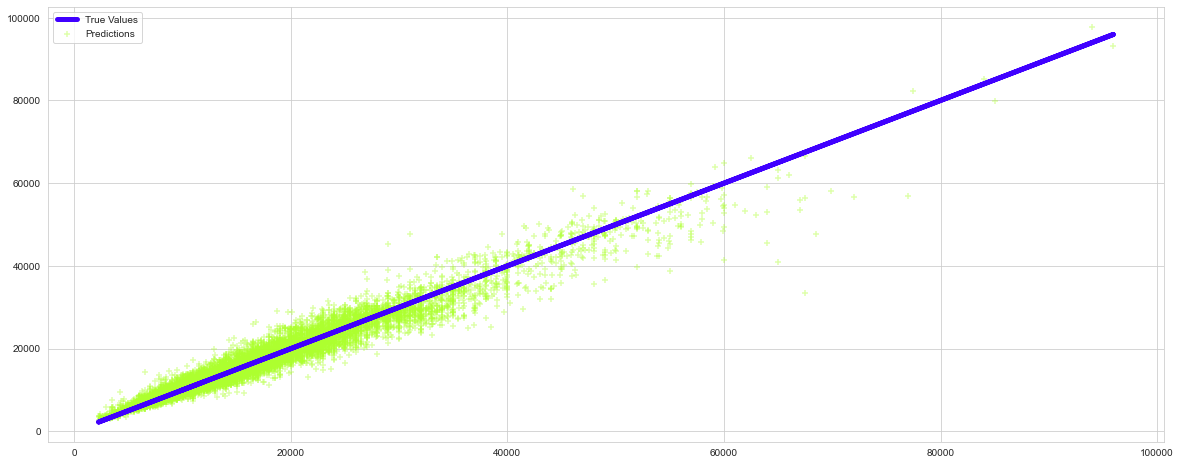

In [26]:
_ = main()

In [27]:
df_predictions = pd.DataFrame({'True Values':Y_test,"Predictions":pred})

In [28]:
df_predictions.sample(n = 10,random_state = 50)

,True Values,Predictions
14698,12390,14046.578125
1908,10990,12453.291992
256,9490,9105.352539
6873,29995,28163.564453
2839,8995,9176.668945
15195,21995,21400.814453
6296,19240,19422.181641
3080,4991,5487.457031
7370,24494,24621.328125
13346,18970,19874.746094


As seen in the graph and in the model metrics, the predictions are very close to the original value.

## *Opening the Black Box*

In [29]:
features,feature_importances = X.columns,xgb.feature_importances_

In [30]:
def relevant_features():
    
    features_list,feature_important_list = list(),list()
    
    for i,v in enumerate(feature_importances):
        if v > np.quantile(feature_importances,0.95):
            features_list.append(features[i])
            feature_important_list.append(v)
            
    return features_list,feature_important_list

Due to the excessive number of predictor variables, I opted to create a function in order to extract the most relevant variables determined by the model.

In [31]:
features,feature_importances = relevant_features()

In [32]:
df_features_importance = pd.DataFrame({"Features":features,"Importance":feature_importances})

In [33]:
df_features_importance = df_features_importance.sort_values(by = "Importance",ascending = True)

In [34]:
def plot_importance(colors):
    
    fig,ax = plt.subplots(1,1,figsize = (20,8))
    
    _ = ax.set_title("Most Important Features")
    _ = plt.barh(df_features_importance["Features"],df_features_importance["Importance"],color = colors)
    plt.savefig("plot_importance.jpeg")

In [35]:
colors = ['#808080', '#e30052','#ff8000','#007fff']

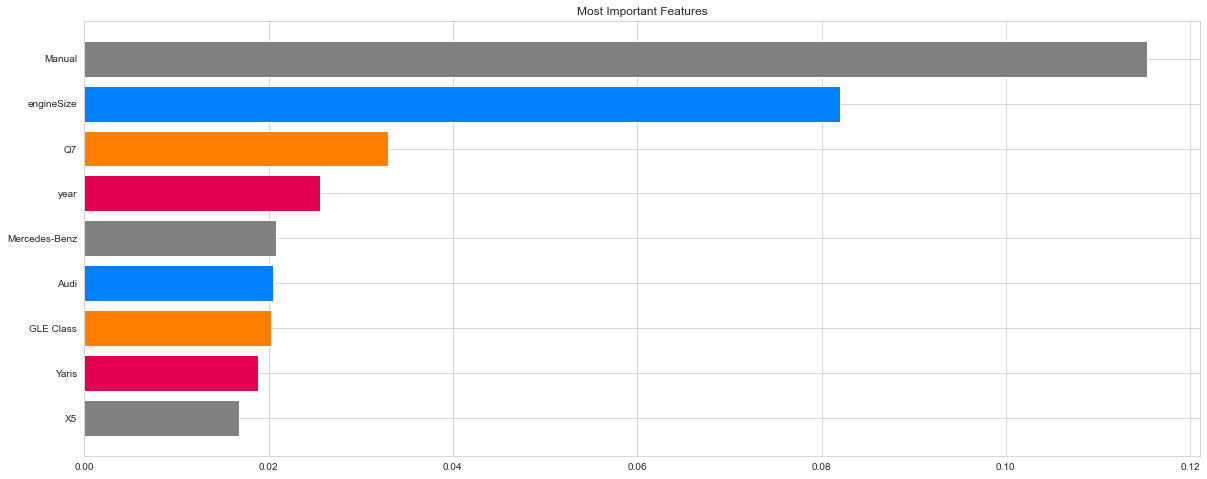

In [36]:
_ = plot_importance(colors)

* If the vehicle has a Manual transmission, the price of the vehicle generally decreases, it is less expensive with an automatic or semi-automatic transmission.



* The engine size is a variable that has a lot of weight. Since the greater the capacity, the greater the technical capacity of the car.



* The year of manufacture includes in the price, since if a vehicle of the same model. It will make the price of the car more expensive, since it will be a more recent model.






* Other variables that complement the predictions well is the vehicle brand, since for example it is well known that Mercedes-benz vehicles belong to high-end manufacturers, which means that the price per car is much higher. Also the number of miles traveled, since generally a vehicle with higher mileage has more wear, which causes a devaluation of the car.

## New Predictions

In [37]:
columns = X.columns

In [38]:
for index,column in enumerate(columns):
   if column == 'year' or column == 'engineSize' or column == 'mileage':
    print(index,column)

165 year
170 engineSize
171 mileage


With the enumerate function, the indices of each object are obtained, in this case of each variable of interest, it will help us to know the exact index number for these variables that do not require OHE.

In [39]:
def predict(manufacturer,model,transmission,year,fuel_type,engineSize,mileage):
    
    data = np.zeros(len(columns))
    
    manufacturer_idx = np.where(columns == manufacturer)[0][0]
    model_idx = np.where(columns == model)[0][0]
    transmission_idx = np.where(columns == transmission)[0][0]
    fuel_type_idx = np.where(columns == fuel_type)[0][0]
    
    data[165] = year
    data[170] = engineSize
    data[171] = mileage

    
    if manufacturer_idx >=0:
        data[manufacturer_idx] = 1

    if model_idx >=0:
        data[model_idx] = 1
        
    if transmission_idx >=0:
        data[transmission_idx] = 1
        
    if fuel_type_idx >=0:
        data[fuel_type_idx] = 1
        
    data = np.asarray([data])
    pred = xgb.predict(data)
    
    return np.round(pred,2)

### *Ford Mustang*

<img src = "https://runcast.tv/wp-content/uploads/2019/12/Ford-Mustang-Shelby-GT350R-2020.jpg" width = 800>

In [40]:
predict('Ford','Mustang','Automatic',2020,'Petrol',5.0,3500)

array([41454.26], dtype=float32)

### *Toyota Corolla*

<img src = "https://img.automexico.com/2021/03/12/23f43741-54ae.jpg" width = 600>

In [41]:
predict('Toyota','Corolla','Automatic',2019,'Hybrid',2.0,18200)

array([23319.46], dtype=float32)

### *Volkswagen Jetta*

<img src = "https://rodatiautos.mx/images/listings/2022-04/82f15b11-1650543996-824.jpg" width = 700>

In [42]:
predict('Volkswagen','Jetta','Automatic',2012,'Petrol',2.0,45000)

array([10718.21], dtype=float32)

### *Audi R8*


<img src = "https://upload.wikimedia.org/wikipedia/commons/c/c8/Audi_R8_-_Flickr_-_Alexandre_Pr%C3%A9vot_%28109%29_%28cropped%29.jpg" width = 700>

In [43]:
predict('Audi','R8','Semi-Auto',2020,'Diesel',5.2,4200)

array([107549.97], dtype=float32)

### *BMW 3 Series*

<img src = "https://hips.hearstapps.com/hmg-prod/amv-prod-cad-assets/images/media/672263/2017-bmw-3-series-in-depth-model-review-car-and-driver-photo-686405-s-original.jpg?fill=2:1&resize=1200:*" width = 800>

In [44]:
predict('BMW','3 Series','Manual',2017,'Diesel',2.0,91000)

array([11244.98], dtype=float32)

### *Hyundi Santa Fe*

<img src = "https://www.diariomotor.com/imagenes/2014/07/hyundai-grand-santa-fe-portada00-dm-700px.jpg" width = 800>

In [45]:
predict('Hyundi','Santa Fe','Automatic',2014,'Diesel',2.2,45000)

array([13663.85], dtype=float32)

### *Mercedes-Benz C-Class*

<img src = "https://www.cnet.com/a/img/resize/290c6e1129ba5372a0a96fc8d736069e745042ed/hub/2018/06/18/7b95ee02-e5b1-48cb-a48f-a360eb2e56ea/ogi1-011-2019-mercedes-benz-c300-first-drive.jpg?auto=webp&fit=crop&height=675&width=1200" width = 800>

In [46]:
predict('Mercedes-Benz','C Class','Automatic',2019,'Petrol',1.5,15000)

array([22906.56], dtype=float32)

### *Skoda Octavia*

<img src = "https://img.autoabc.lv/Skoda-Octavia/Skoda-Octavia_2017_Hecbeks_22318111512_4.jpg" width = 700 >

In [47]:
predict('Skoda','Octavia','Manual',2017,'Petrol',1.4,32000)

array([11300.14], dtype=float32)

### *Vauxhall Corsa*

<img src = "https://www.autocar.co.uk/sites/autocar.co.uk/files/styles/gallery_slide/public/vxl-corsa-vxr-rt-2015004.jpg?itok=vmXBqiT8" width = 800>

In [48]:
predict('Vauxhall','Corsa','Manual',2018,'Petrol',1.4,17000)

array([8817.08], dtype=float32)

## *Save Model*

In [49]:
xgb.save_model("C:/Users/PC/Desktop/Car-Sales/app/cars_sales_model.json")

## *Save JSON File*

Create a JSON file with the name of the input variables. In order to facilitate the pre-processing of new data data. Since categorical variables, such as the streaming model, are in One Hot Encoding format.

In [50]:
import json

In [51]:
columns = {"data_columns":[col for col in columns]}

In [52]:
with open("C:/Users/PC/Desktop/Car-Sales/app/columns.json","w") as F:

    F.write(json.dumps(columns))